In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict


In [6]:
traffic = pd.read_csv(
    "LIVE_CAPTURE.csv",
    encoding="latin1",
    on_bad_lines="skip",
    low_memory=False
)

traffic.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,192.168.2.13,8.8.4.4,QUIC,1292,"Initial, DCID=6160c941423d4e4e, PKN: 1, CRYPTO..."
1,2,0.000021,192.168.1.50,192.168.1.1,TCP,850,"68000,80,0.6"
2,3,0.000201,192.168.2.13,8.8.4.4,QUIC,1292,"Initial, DCID=6160c941423d4e4e, PKN: 2, CRYPTO..."
3,4,0.000693,192.168.2.13,8.8.4.4,QUIC,121,"0-RTT, DCID=6160c941423d4e4e"
4,5,0.001350,192.168.2.13,8.8.4.4,QUIC,305,"0-RTT, DCID=6160c941423d4e4e"


In [ ]:
traffic.columns = traffic.columns.str.strip()

traffic = traffic.rename(columns={
    'Time': 'time',
    'Source': 'src_ip',
    'Destination': 'dst_ip',
    'Protocol': 'protocol',
    'Length': 'length'
})

traffic = traffic[['time','src_ip','dst_ip','protocol','length']]
traffic.head()

,time,src_ip,dst_ip,protocol,length
0,0.000000,192.168.2.13,8.8.4.4,QUIC,1292
1,0.000021,192.168.1.50,192.168.1.1,TCP,850
2,0.000201,192.168.2.13,8.8.4.4,QUIC,1292
3,0.000693,192.168.2.13,8.8.4.4,QUIC,121
4,0.001350,192.168.2.13,8.8.4.4,QUIC,305


In [8]:
flows = traffic.groupby(['src_ip','dst_ip','protocol'])

features = pd.DataFrame()
features['packet_count'] = flows.size()
features['total_bytes'] = flows['length'].sum()
features['avg_packet_size'] = flows['length'].mean()
features['duration'] = flows['time'].max() - flows['time'].min()

features.reset_index(inplace=True)
features.fillna(0, inplace=True)

features.head()

,src_ip,dst_ip,protocol,packet_count,total_bytes,avg_packet_size,duration
0,0.0.0.0,255.255.255.255,DHCP,1,344,344.000000,0.000000
1,1.1.1.1,192.168.2.13,DNS,11,2394,217.636364,105.449858
2,13.107.136.254,192.168.2.13,TCP,9,3418,379.777778,0.041488
3,13.107.136.254,192.168.2.13,TLSv1.2,7,2944,420.571429,0.032341
4,13.64.73.29,192.168.2.13,TCP,14,828,59.142857,92.098229


In [9]:
def estimate_attack(row):
    pkt = row['packet_count']
    dur = row['duration']
    avg_size = row['avg_packet_size']

    # DoS: flooding
    if pkt > 200 and dur < 2:
        return 'dos'

    # Probe: scanning behavior
    elif pkt > 50 and dur >= 2 and dur < 10:
        return 'probe'

    # R2L: repeated small packets over long session
    elif pkt > 20 and avg_size < 200 and dur >= 10:
        return 'r2l'

    # U2R: rare abnormal tiny traffic
    elif pkt < 10 and avg_size < 100 and dur < 1:
        return 'u2r'

    else:
        return 'benign'


In [10]:
plt.ion()   # interactive plotting
attack_counter = defaultdict(int)

In [11]:
def update_dashboard(counter):
    plt.clf()
    plt.bar(
        counter.keys(),
        counter.values(),
        color=['green','orange','red','purple','brown']
    )
    plt.title("Live Intrusion Detection Dashboard")
    plt.xlabel("Traffic Type")
    plt.ylabel("Count")
    plt.pause(0.5)

Flow 0 | Packets=1 | AvgSize=344.0 | Duration=0.0s | Detected=BENIGN


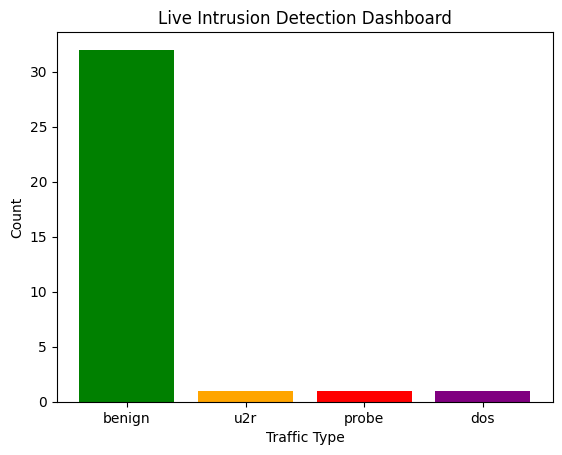

Flow 1 | Packets=11 | AvgSize=217.6 | Duration=105.45s | Detected=BENIGN


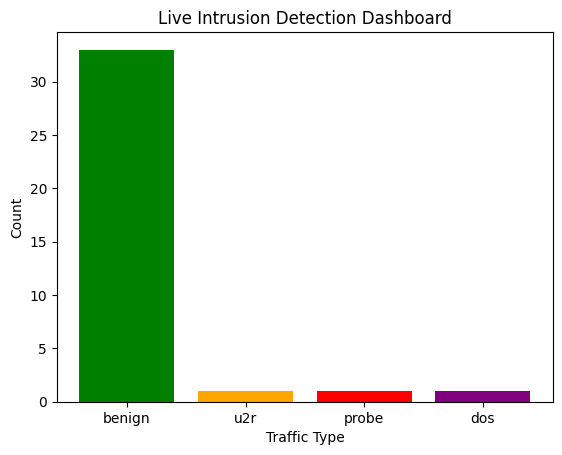

Flow 2 | Packets=9 | AvgSize=379.8 | Duration=0.04s | Detected=BENIGN


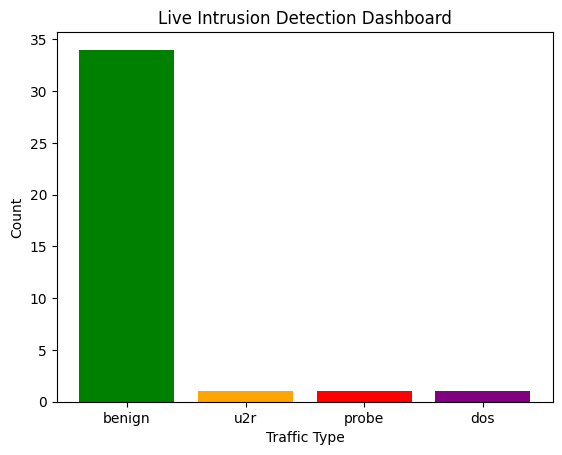

Flow 3 | Packets=7 | AvgSize=420.6 | Duration=0.03s | Detected=BENIGN


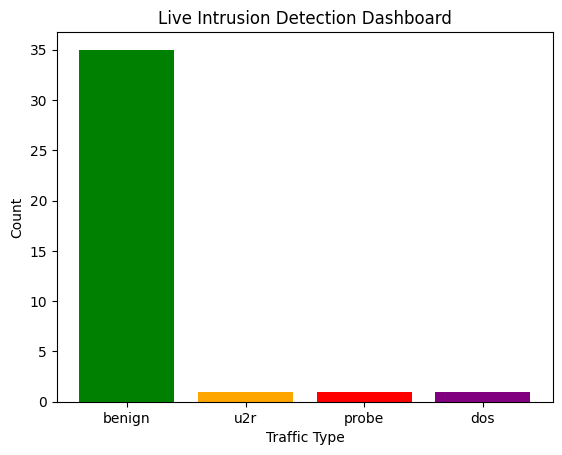

KeyboardInterrupt: 

In [13]:
for i in range(len(features)):
    row = features.iloc[i]

    attack_type = estimate_attack(row)
    attack_counter[attack_type] += 1

    print(
        f"Flow {i} | "
        f"Packets={row['packet_count']} | "
        f"AvgSize={round(row['avg_packet_size'],1)} | "
        f"Duration={round(row['duration'],2)}s | "
        f"Detected={attack_type.upper()}"
    )

    update_dashboard(attack_counter)
    time.sleep(1)


In [14]:
# Generate labels ONCE (for training only)
features['label'] = features.apply(estimate_attack, axis=1)

# Encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
features['label_enc'] = le.fit_transform(features['label'])


In [16]:
from sklearn.model_selection import train_test_split

X = features[['packet_count', 'total_bytes', 'avg_packet_size', 'duration']]
y = features['label_enc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [26]:
import pickle
from sklearn.ensemble import RandomForestClassifier

# Your training code...
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 3.4 MB/s eta 0:00:22
    --------------------------------------- 1.3/72.0 MB 3.4 MB/s eta 0:00:22
   - -------------------------------------- 2.1/72.0 MB 3.5 MB/s eta 0:00:21
   - -------------------------------------- 2.6/72.0 MB 3.4 MB/s eta 0:00:21
   - -------------------------------------- 3.4/72.0 MB 3.4 MB/s eta 0:00:21
   -- ------------------------------------- 3.9/72.0 MB 3.3 MB/s eta 0:00:21
   -- ------------------------------------- 4.2/72.0 MB 2.9 MB/s eta 0:00:24
   -- ------------------------------------- 5.0/72.0 MB 3.0 MB/s eta 0:00:23
   --- ------------------------------------ 5.8/72.0 MB 3.0 MB/s eta 0:00:22
   --- ------------------------------------ 6.3/72.0 MB 3.1 MB/s eta 0:00:22
   --- ------------------------------------ 7.1/72.0 MB 3.1 MB/s eta 0:00:21
   ---- ----------------------------------- 7.9/72.0 MB 3.1 MB/s eta 0:00:21
   ---

In [27]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(le.classes_)
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_class=5, ...)

In [28]:
from sklearn.metrics import accuracy_score

rf_acc  = accuracy_score(y_test, rf.predict(X_test))
xgb_acc = accuracy_score(y_test, xgb.predict(X_test))

print("Random Forest:", rf_acc)
print("XGBoost      :", xgb_acc)

Random Forest: 0.9736842105263158
XGBoost      : 1.0


In [29]:
import joblib

joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [30]:
def ml_detect(row):
    data = [[
        row['packet_count'],
        row['total_bytes'],
        row['avg_packet_size'],
        row['duration']
    ]]
    pred = rf.predict(data)[0]
    return le.inverse_transform([pred])[0]


c:\Users\ADHIRAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Flow 0 | Packets=1 | AvgSize=344.0 | Duration=0.0s | Detected=BENIGN


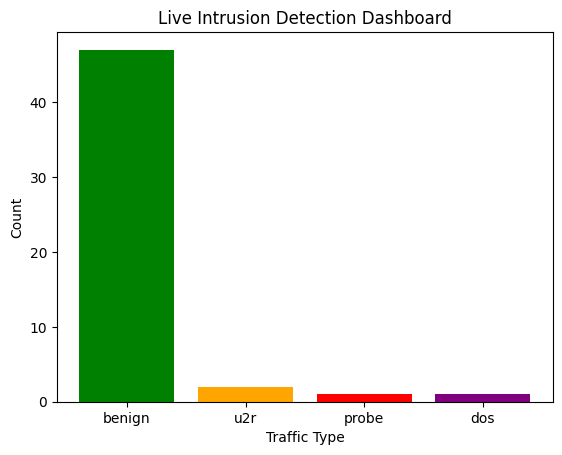

Flow 1 | Packets=11 | AvgSize=217.6 | Duration=105.45s | Detected=BENIGN


c:\Users\ADHIRAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


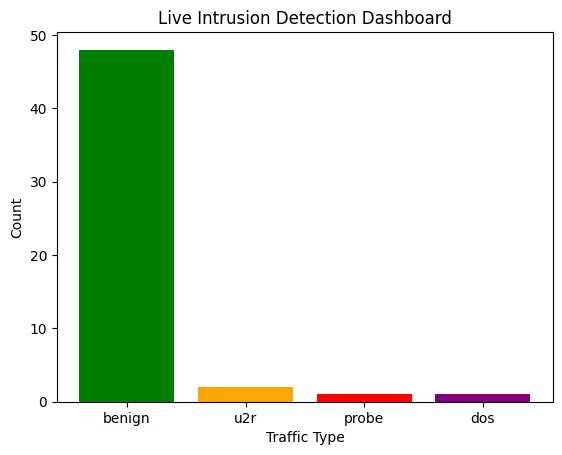

Flow 2 | Packets=9 | AvgSize=379.8 | Duration=0.04s | Detected=BENIGN


c:\Users\ADHIRAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


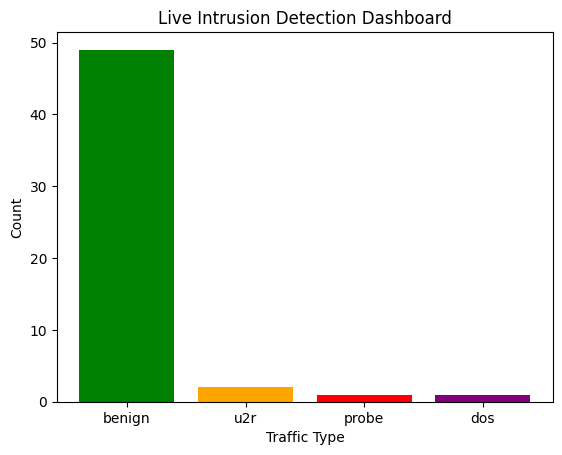

Flow 3 | Packets=7 | AvgSize=420.6 | Duration=0.03s | Detected=BENIGN


c:\Users\ADHIRAJ\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


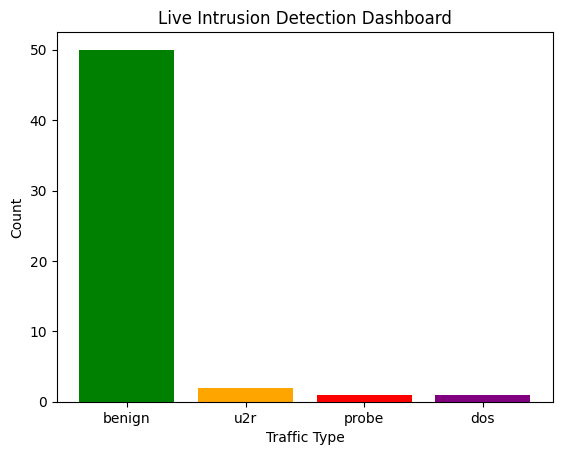

KeyboardInterrupt: 

In [31]:
for i in range(len(features)):
    row = features.iloc[i]

    # 🔥 ML‑based detection
    attack_type = ml_detect(row)

    attack_counter[attack_type] += 1

    print(
        f"Flow {i} | "
        f"Packets={row['packet_count']} | "
        f"AvgSize={round(row['avg_packet_size'],1)} | "
        f"Duration={round(row['duration'],2)}s | "
        f"Detected={attack_type.upper()}"
    )

    update_dashboard(attack_counter)
    time.sleep(1)
